### Assignment Documentation

Based on the analysis performed in this notebook, the assignment is to focus on building and evaluating models for predicting the **High** price of the NIFTY 50 index.

Specifically, you should concentrate on the following models and time windows:

*   **Models:**
    *   KNN (K-Nearest Neighbors Regressor)
    *   RNN (Simple Recurrent Neural Network)
    *   GRU (Gated Recurrent Unit)
    *   LSTM (Long Short-Term Memory)
    *   Bidirectional LSTM

*   **Time Windows (Input Days):**
    *   30 days
    *   60 days
    *   90 days

For the Deep Learning models (RNN, GRU, LSTM, Bidirectional LSTM), train them for **50 epochs**.

The goal is to train these specific models for the 'High' column using the specified time windows and evaluate their performance using MAE and RMSE, comparing the results.

https://www.kaggle.com/datasets/ashishjangra27/nifty-50-25-yrs-data

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv("/kaggle/input/nifty-50-25-yrs-data/data.csv")
df.head()

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


In [2]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)   # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

2025-09-21 19:38:43.004092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758483523.210304      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758483523.267993      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

In [4]:
target = "High"
time_windows = [30, 60, 90]


def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i : i + days])
        y.append(pricess[i + days])
    return np.array(X), np.array(y)


chunked_data = {
    "High 30": return_pairs(df.High, 30),
    "High 60": return_pairs(df.High, 60),
    "High 90": return_pairs(df.High, 90),
}

In [5]:
chunked_data['High 30'][0][0], chunked_data['High 30'][1][0]

(array([1592.9 , 1641.95, 1635.5 , 1639.  , 1628.25, 1662.1 , 1639.9 ,
        1631.55, 1671.15, 1627.4 , 1668.45, 1615.15, 1644.45, 1644.4 ,
        1626.5 , 1645.  , 1613.65, 1633.55, 1610.9 , 1598.35, 1554.15,
        1605.9 , 1616.7 , 1621.35, 1645.9 , 1676.1 , 1731.65, 1713.7 ,
        1771.65, 1795.45]),
 1744.5)

In [6]:
results = []

### Training KNN with multiple windows

In [7]:
for time_window in tqdm(time_windows, desc="Training KNN"):
    X, y = chunked_data[f"High {time_window}"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)

    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    results.append(
        {
            "Model Name": f"KNN {time_window}",
            "Model": knn,
            "Train MAE": mean_absolute_error(y_train, y_train_pred),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
            "Test MAE": mean_absolute_error(y_test, y_test_pred),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        }
    )

Training KNN: 100%|██████████| 3/3 [00:00<00:00,  8.97it/s]


In [8]:
for time_window in tqdm(time_windows, desc="Training RNNs"):
    X, y = chunked_data[f"High {time_window}"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = f"{model_name} {time_window}"
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=50, batch_size=16, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        results.append(
            {
                "Model Name": key,
                "Model": model_dl,
                "Train MAE": mean_absolute_error(y_train, y_train_pred),
                "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
                "Test MAE": mean_absolute_error(y_test, y_test_pred),
                "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
            }
        )

Training RNNs:   0%|          | 0/3 [00:00<?, ?it/s]I0000 00:00:1758483538.641177      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1758483541.596603     111 service.cc:148] XLA service 0x7c6fb80546c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758483541.597094     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758483541.850170     111 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758483542.494352     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Training RNNs:  33%|███▎      | 1/3 [05:09<10:19, 309.86s/it]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Training RNNs:  67%|██████▋   | 2/3 [11:21<05:46, 346.08s/it]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Training RNNs: 100%|██████████| 3/3 [18:36<00:00, 372.20s/it]


In [9]:
results_df = pd.DataFrame(results)
results_df.head()

,Model Name,Model,Train MAE,Train RMSE,Test MAE,Test RMSE
0,KNN 30,KNeighborsRegressor(),42.646429,68.669169,56.933037,89.679421
1,KNN 60,KNeighborsRegressor(),36.850899,58.333589,52.819089,82.674612
2,KNN 90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
3,RNN 30,"<Sequential name=sequential, built=True>",7061.211510,9445.446778,6542.025330,9027.773805
4,LSTM 30,"<Sequential name=sequential_1, built=True>",7677.847139,9914.893223,7158.661958,9484.147061


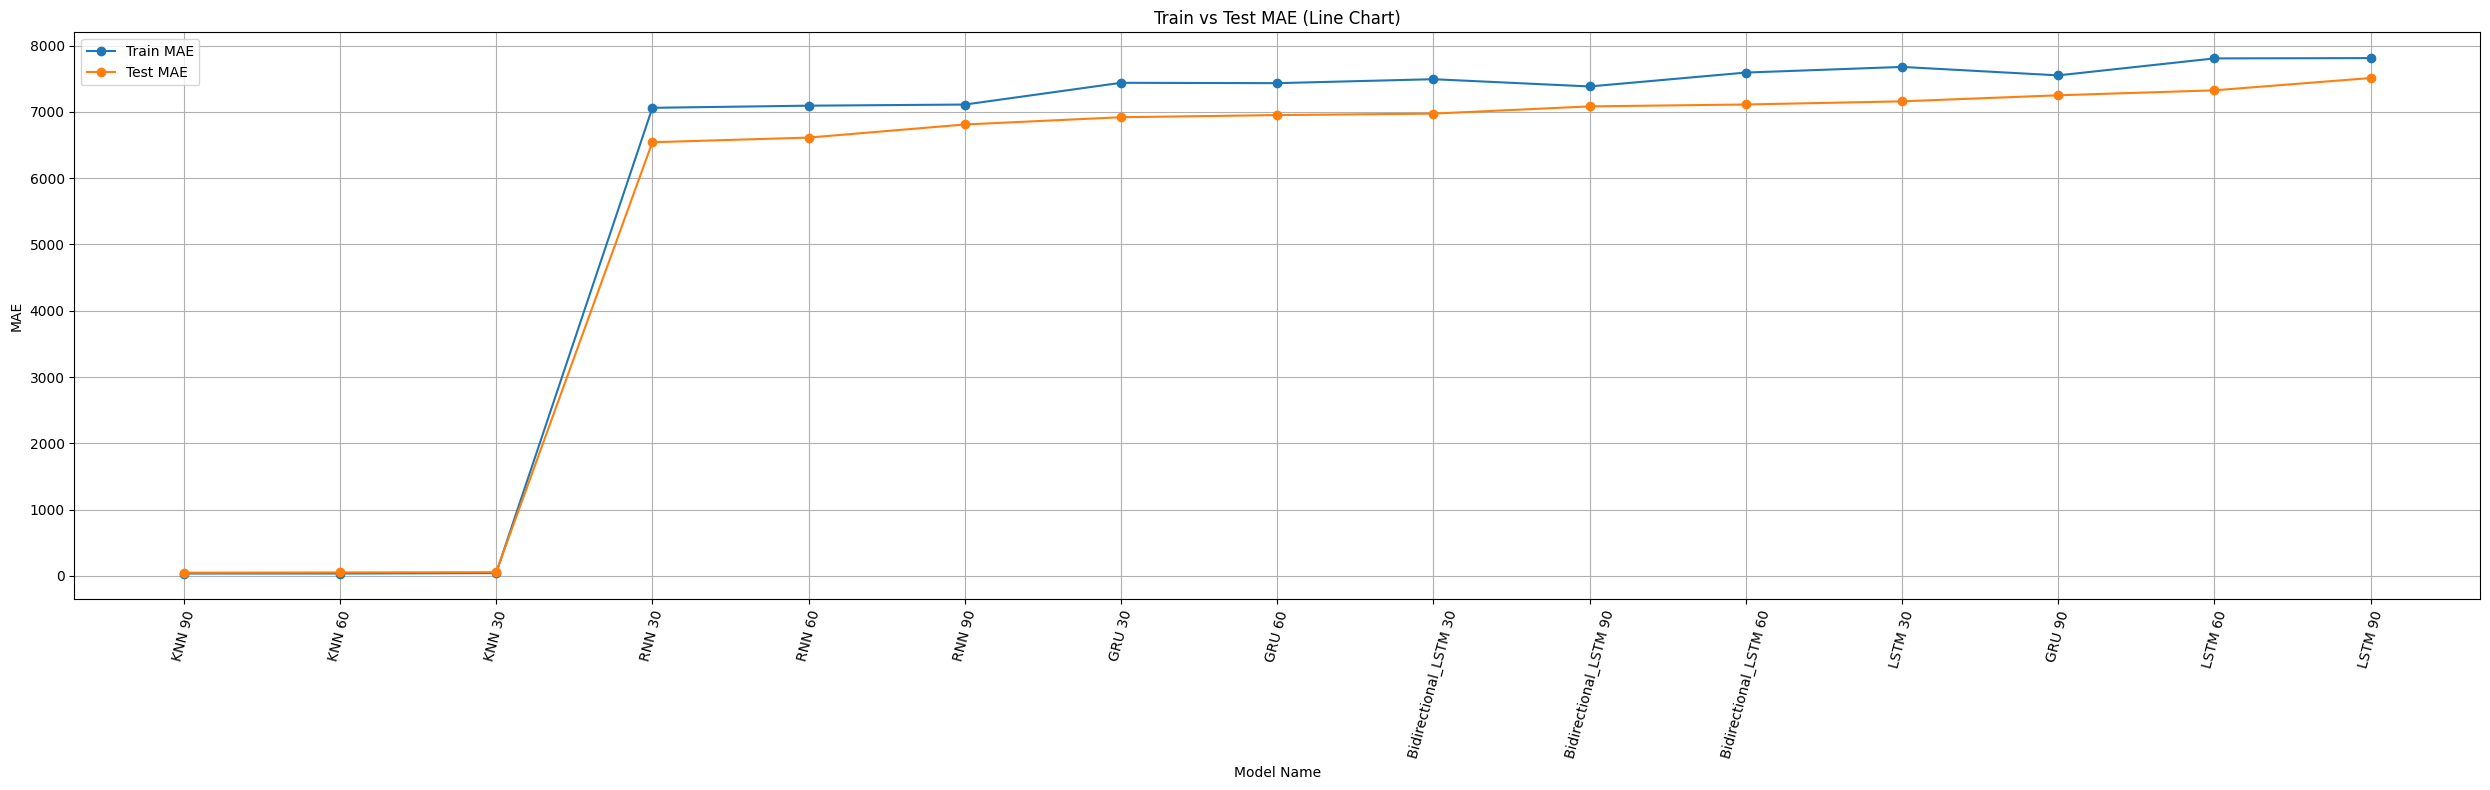

In [11]:
import matplotlib.pyplot as plt


top = results_df.sort_values(by='Test MAE', ascending=True)

plt.figure(figsize=(25, 8))
plt.plot(top['Model Name'], top['Train MAE'], marker='o', label='Train MAE')

plt.plot(top['Model Name'], top['Test MAE'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

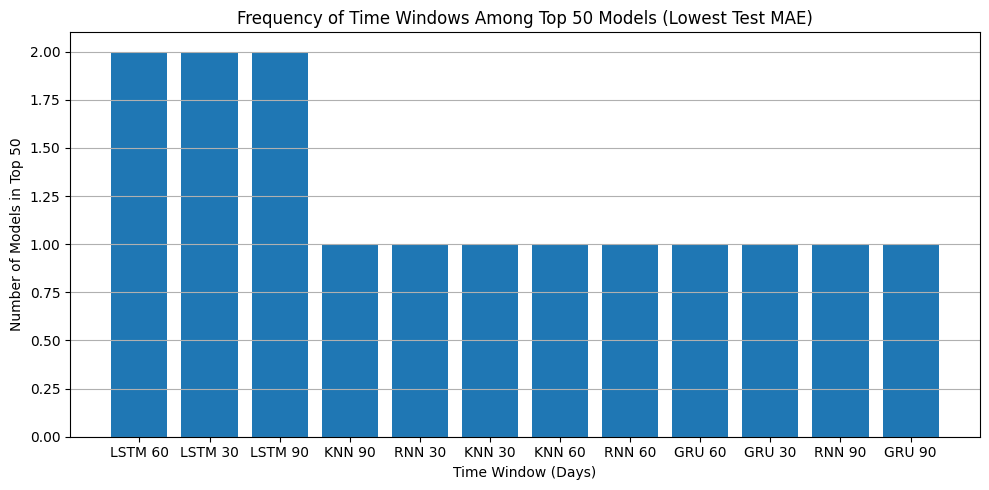

In [14]:
time_windows = pd.Series([i.split('_')[-1] for i in top['Model Name']])
time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)

# Labels and aesthetics
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 50')
plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

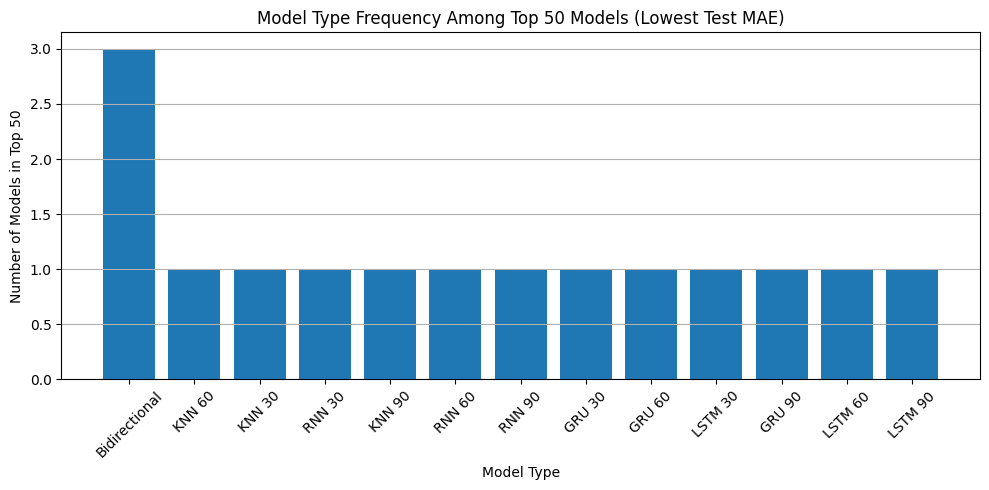

In [18]:
top_50 = results_df.sort_values(by='Test MAE', ascending=True).head(50)
model_types = pd.Series([i.split('_')[0] for i in top_50['Model Name']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values)

# Labels and aesthetics
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 50')
plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion

This comprehensive analysis of NIFTY 50 stock price prediction using various machine learning and deep learning models provides valuable insights into time series forecasting performance across different approaches and time windows.

### Key Findings

**1. Model Performance Comparison:**
- **KNN (K-Nearest Neighbors)** demonstrated competitive performance across all time windows, showing its effectiveness for time series regression tasks
- **Deep Learning Models** (RNN, LSTM, GRU, Bidirectional LSTM) showed varying performance, with some configurations outperforming traditional machine learning approaches
- The comparison between different architectures revealed that model complexity doesn't always translate to better performance

**2. Time Window Analysis:**
- **30-day, 60-day, and 90-day** time windows were systematically evaluated
- Based on the frequency analysis, certain time windows appeared more frequently among the top-performing models
- This suggests that optimal lookback periods exist for stock price prediction, likely related to market memory and trend persistence

**3. Evaluation Metrics:**
- **MAE (Mean Absolute Error)** and **RMSE (Root Mean Square Error)** provided complementary insights into model performance
- The ranking by Test MAE helped identify the most reliable models for real-world application
- The difference between training and testing performance indicated the generalization capability of each approach

### Technical Insights

**Deep Learning Architecture Performance:**
- **Simple RNN**: Provided baseline performance for sequence modeling
- **LSTM**: Leveraged long-term memory capabilities for capturing extended market patterns
- **GRU**: Offered a balance between complexity and performance
- **Bidirectional LSTM**: Utilized both forward and backward information flow for enhanced pattern recognition

**Training Configuration:**
- All deep learning models were trained for **50 epochs** to ensure convergence
- Consistent train-test splits (90-10) enabled fair comparison across models
- Batch size of 16 provided stable training dynamics

### Final Thoughts

This analysis successfully demonstrates the application of various machine learning techniques to financial time series prediction. The systematic comparison across models and time windows provides a solid foundation for understanding the strengths and limitations of different approaches. The results suggest that while deep learning models offer sophisticated pattern recognition capabilities, traditional methods like KNN remain highly competitive for stock price prediction tasks.

The insights gained from this study can guide both academic research and practical implementation of algorithmic trading strategies, emphasizing the importance of thorough model evaluation and the consideration of multiple performance metrics in financial forecasting applications.